In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from toolz import concat
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import jensenshannon
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
## update data
def filter_df(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#008C8D','white','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
print(data_all.index.get_level_values('age').unique())
m_data = data_all.query('age<100')

Index([  3,   4,   5,   7,   8,   9,  12,  16,  20,  24,  28,  32,  36,  40,
        44,  48,  52,  56,  60,  64,  68,  72,  78,  80,  84,  90, 103],
      dtype='int64', name='age')


In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False) if len(x)>n else x.sample(n=len(x),replace=False)).reset_index(level=0, drop=True)
print(data_all.index.get_level_values('age').unique())
f_data = data_all.query('age<100')

Index([  3,   4,   5,   7,   8,   9,  12,  16,  20,  24,  28,  32,  36,  40,
        44,  48,  52,  56,  60,  64,  68,  72,  78,  80,  84,  90, 127],
      dtype='int64', name='age')


In [7]:
# use only common ages
f_ages = f_data.index.get_level_values('age').unique().to_numpy()
m_ages = m_data.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
m_data = m_data.loc[m_data.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_data.loc[f_data.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

m_data= m_data.groupby('age').mean()
f_data = f_data.groupby('age').mean()

data=pd.concat([m_data,f_data])
#data.set_index('sex',inplace=True,append=True)

In [8]:
#correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman').to_numpy()

In [24]:
# Calculate p-values using scipy's pearsonr function
from scipy.stats import spearmanr
correlation_matrix = m_data.corrwith(f_data, axis=0, method='spearman')

p_values = m_data.apply(lambda col: spearmanr(col, f_data[col.name])[1]) #change by number of syllables used

#colors = ['purple' if value > 0 else 'orange' for value in new_diff]

# Combine results into a DataFrame
result_df = pd.DataFrame({'Correlation': correlation_matrix, 'P-Value': p_values})

print(result_df)

    Correlation       P-Value
5     -0.020855  9.194557e-01
11     0.569231  2.405671e-03
0      0.587009  1.619119e-03
3      0.528205  5.542200e-03
12     0.809915  5.367461e-07
20     0.630769  5.510418e-04
32     0.813333  4.399314e-07
13     0.227350  2.640133e-01
4     -0.111111  5.889407e-01
33     0.299145  1.376581e-01
28     0.658803  2.526112e-04
9     -0.175385  3.914569e-01
19    -0.166496  4.162701e-01
38     0.675214  1.540709e-04
39     0.500855  9.154929e-03
7     -0.025641  9.010508e-01
34    -0.096752  6.382238e-01
23     0.481026  1.285702e-02
26     0.620513  7.196101e-04
18     0.776410  3.124169e-06
15     0.217778  2.851898e-01
35     0.552821  3.401670e-03
17    -0.372308  6.106622e-02
8      0.433846  2.680468e-02
1      0.352479  7.738168e-02
36     0.434530  2.653892e-02
16     0.198632  3.306738e-01
21     0.427009  2.958230e-02
29    -0.111795  5.866354e-01
2      0.264957  1.908385e-01
24     0.440684  2.424161e-02
14     0.381197  5.468157e-02
22     0.3

In [26]:
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
sorted_result_df

,Correlation,P-Value
32,0.813333,4.399314e-07
12,0.809915,5.367461e-07
18,0.776410,3.124169e-06
38,0.675214,1.540709e-04
28,0.658803,2.526112e-04
20,0.630769,5.510418e-04
26,0.620513,7.196101e-04
27,0.589060,1.544560e-03
0,0.587009,1.619119e-03
11,0.569231,2.405671e-03


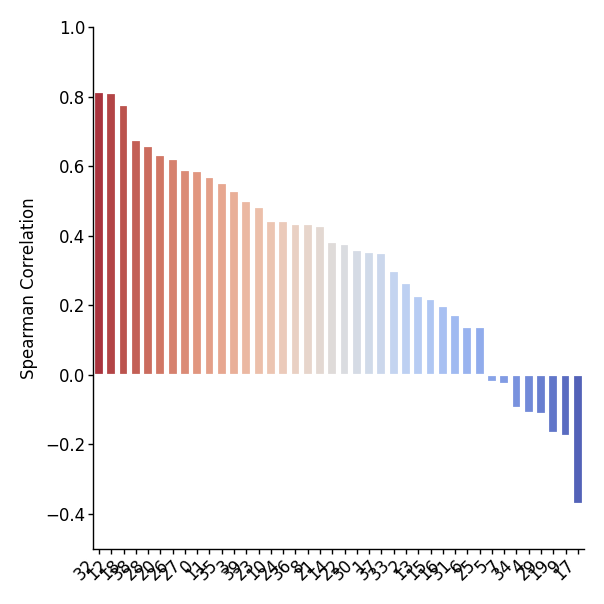

In [23]:
# Create a DataFrame from the correlation values list
sorted_result_df = result_df.sort_values(by='Correlation', ascending=False)
# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(3,3)
sns.barplot(x=list(range(len(sorted_result_df))), y='Correlation', data=sorted_result_df, dodge=True, palette ="coolwarm_r" )
plt.xticks(rotation=45, ha='right')
#plt.title('Spearman Correlation between Columns of df1 and df2')
#plt.xlabel('Columns in df1')
plt.ylim([-0.5,1])
plt.ylabel('Spearman Correlation')
ax.set_xticklabels(sorted_result_df.index.values)
plt.tight_layout()
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "simons"/ 'fvm_syll_change_crosscorr.pdf')

In [22]:
range(len(sorted_result_df))

range(0, 40)

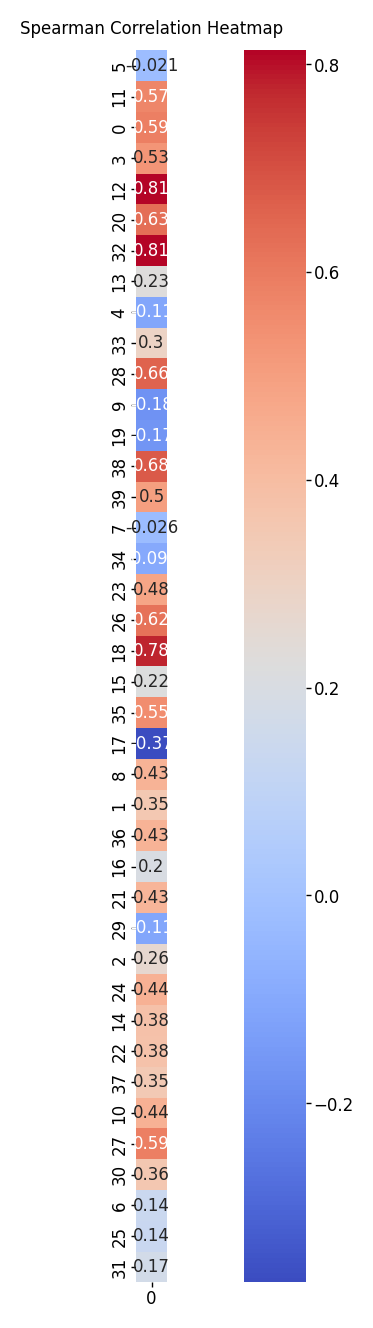

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Spearman Correlation Heatmap")
plt.show()